In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.optimize as opt
import scipy.io as sio
import analysis_utils as au
import importlib

In [8]:
len(PSD_freq)

5001

Let's try just doing standard optimal filter assuming stationary and see how well it does

1
2


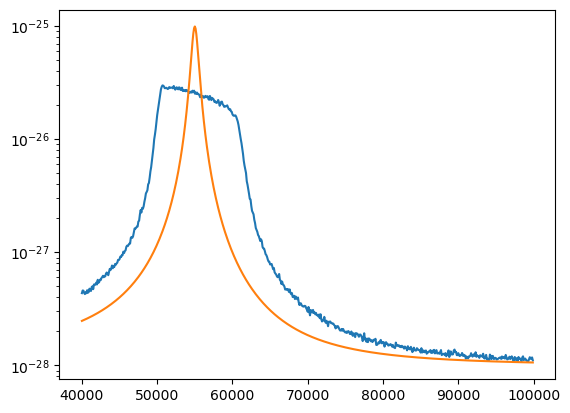

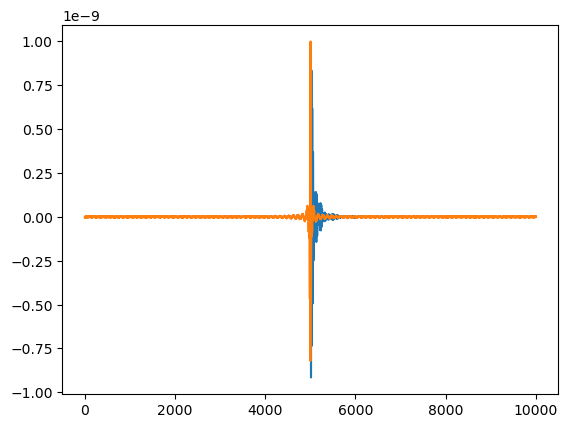

In [54]:
importlib.reload(au)

# Load in noise and response templates
yfb_l = np.array([1000])*2*np.pi
for yfb in yfb_l:

    numbins = int(2*5*10**4*100*2*np.pi/yfb)

    filename = 'D:/Simulation Data/240529/Frequency modulation/yfb' + str(round(yfb/2/np.pi))

    data = au.load_data_hdf5(filename+'/Noise/PSD.hdf5')
    PSD_freq = data['frequency']
    PSD_noise = data['J']

    data = au.load_data_hdf5(filename+'/Kicks/avr_resp.hdf5')
    avr_resp = data['x']

    lb = 400
    ub = 1000
    plt.figure()
    plt.plot(PSD_freq[lb:ub], PSD_noise[lb:ub])
    plt.plot(PSD_freq[lb:ub], au.Linewidth2(np.array(PSD_freq[lb:ub]), 0.3*10**(-12), 55000, 1000, 10**(-28)))
    plt.yscale('log')

    plt.figure()
    plt.plot(avr_resp)

    phi_t = au.make_optimal_filter_ns(avr_resp, PSD_noise, PSD_freq)

    plt.plot(phi_t*10**(-9))

    corr_max = []
    #corr_arg = []
    #corr_data_l = np.zeros((1000, numbins))
    for i in range(1000):
        data = au.load_data_hdf5(filename+'/Kicks/' + str(i) +'.hdf5')
        x = data['x']
        cm = au.optimal_filter(phi_t, x)
        corr_max.append(cm)
    print(1)
    
    corr_max_n = []
    #corr_data_l_n = np.zeros((1000, numbins))
    np.random.seed(3716)
    for i in range(1000):
        data = au.load_data_hdf5(filename+'/Noise/' + str(i) +'.hdf5')
        x = data['x']
        cm = au.optimal_filter_noise(phi_t, x)
        corr_max_n.append(cm)
    print(2)
    

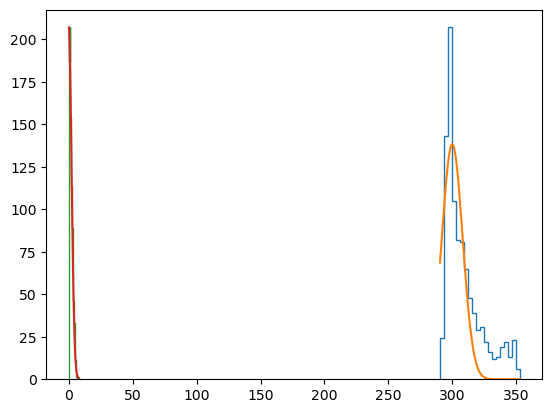

In [55]:
hist1, bins1, fit1, x_hist1, fitted1 = au.histogram_and_fit(corr_max, 20, 5, fit = True, plot = False)
hist2, bins2, fit2, x_hist2, fitted2 = au.histogram_and_fit(corr_max_n, 20, 5, fit = True, plot = False)

plt.stairs(hist1, bins1*300/fit1[1])
plt.plot(x_hist1*300/fit1[1], fitted1)
plt.stairs(hist2/np.max(hist2)*np.max(hist1), bins2*300/fit1[1])
plt.plot(x_hist2*300/fit1[1], fitted2/np.max(hist2)*np.max(hist1))

In [56]:
print(fit1[2]/fit1[1]*300)
print(fit2[2]/fit1[1]*300)

8.102412185588534
2.204699252872823


In [ ]:
# First let's just look at average response and J that we made in the standard way and see how well it manages to reconstruct the impulses

filename_1 = 'D:/Simulation Data/240501/optimal filter/'
yfb_l = np.array([1])*2*np.pi
for yfb in yfb_l:
    
    numbins = int(2*5*10**4*100*2*np.pi/yfb)
    time = np.linspace(0, numbins/5/10**5/2, numbins)

    filename = 'D:/Simulation Data/240501/yfb' + str(round(yfb/2/np.pi))
    data = sio.loadmat(filename+'/Noise/PSD.mat')
    PSD_freq = data['frequency'][0]
    PSD_noise = data['J'][0]
    fit_PSD, cov_PSD = opt.curve_fit(Linewidth2, PSD_freq[1:-1], PSD_noise[1:-1], p0 = [10**(-13), w0/2/np.pi, y+yfb, 10**(-28)])
    print(fit_PSD)
    fitted_PSD = Linewidth2(PSD_freq, *fit_PSD)
    fitted_PSD2 = Linewidth(PSD_freq, *fit_PSD[:-1])

    filename = 'D:/Simulation Data/240501/yfb' + str(round(yfb/2/np.pi))
    data = sio.loadmat(filename+'/Kicks/avr_resp.mat')
    avr_resp = data['x'][0]
    print(len(time))
    print(len(avr_resp))
    fit_resp, cov_resp = opt.curve_fit(impulse_resp, time, avr_resp, p0 = [time[int(numbins/2)], 10*10**(-10), y+yfb, w0])
    print(fit_resp)
    fitted_resp = impulse_resp(time, *fit_resp)

    fitted_PSD3 = Linewidth(PSD_freq, fit_PSD[0], fit_resp[3]/2/np.pi, fit_resp[2]/2/np.pi)

    stilde = np.fft.rfft(fitted_resp)
    sfreq = np.fft.rfftfreq(len(avr_resp),d=1e-6)
    J_out = np.interp(sfreq, PSD_freq, PSD_noise)
    phi = stilde/J_out

    phi_t = np.fft.irfft(phi)
    phi_t = phi_t/np.max(phi_t)

    corr_max = []
    #corr_arg = []
    #corr_data_l = np.zeros((1000, numbins))
    for i in range(1000):
        data = sio.loadmat(filename+'/Kicks/' + str(i) +'.mat')
        x = data['x'][0]
        corr_data = np.abs(scisig.correlate(x, phi_t, mode = 'same'))
        #corr_data_l[i]= corr_data
        corr_max.append(np.max(corr_data[int(numbins/2-numbins/10):int(numbins/2+numbins/10)]))
        #corr_arg.append(np.argmax(corr_data))
    print(1)
    
    corr_max_n = []
    #corr_data_l_n = np.zeros((1000, numbins))
    np.random.seed(3716)
    for i in range(1000):
        data = sio.loadmat(filename+'/Noise/' + str(i) +'.mat')
        x = data['x'][0]
        corr_data = np.abs(scisig.correlate(x, phi_t, mode = 'same'))
        #corr_data_l_n[i]= corr_data
        m = int(np.random.uniform(0, len(corr_data[int(numbins/2-numbins/10):int(numbins/2+numbins/10)])))
        corr_max_n.append(corr_data[int(numbins/2-numbins/10)+m])
    print(2)
    #x_l_lp = np.zeros((1000, numbins))
    
    amp_max = []
    for i in range(1000):
        data = sio.loadmat(filename+'/Kicks/' + str(i) +'.mat')
        x = data['x'][0]
        x = butter_bandpass_filter(x, 30000, 80000, fs = 10**6, order =5)
        amp_max.append(np.max(x))
        #x_l_lp[n] = x_lp
    print(3)
    #x_ln_lp = np.zeros((1000, numbins))
    amp_max_n = []
    np.random.seed(3716)
    for i in range(1000):
        data = sio.loadmat(filename+'/Noise/' + str(i) +'.mat')
        x = data['x'][0]
        x = butter_bandpass_filter(x, 30000, 80000, fs = 10**6, order =5)
        m = int(np.random.uniform(0, numbins))
        amp_max_n.append(x[m])
        #x_ln_lp[n] = x_lp
    
    analysis_dict = {'Kicks': corr_max, 'Kicks noise': corr_max_n, 'Band-pass filter': amp_max, 'Band-pass filter noise': amp_max_n}
    sio.savemat(filename_1 + 'analysis' + str(int(yfb/2/np.pi)) +'.mat', analysis_dict)